In [2]:
import json
import requests
url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json"
response = requests.get(url)
sarcasm_data = response.json()

In [4]:
sarcasm_data[1]

{'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
 'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 'is_sarcastic': 0}

In [6]:
sentences = []
labels = []
links = []

for item in sarcasm_data:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    links.append(item['article_link'])

In [7]:
print(len(sentences))
print(sentences[:3])
print(labels[:3])
print(links[:3])

26709
["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "mom starting to fear son's web series closest thing she will have to grandchild"]
[0, 0, 1]
['https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365', 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697']


In [8]:
training_size = 20000

In [9]:
# conver data into training and test sets
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [10]:
print(len(training_labels))
print(len(testing_labels))

20000
6709


In [11]:
# Load Class/Function
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
# Set Hyperparameters
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = "OOV"

In [14]:
import numpy as np
# tokenizing and padding - preparing data for training

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen = max_length,
truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length,
truncating = trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [16]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print("Original review:\n\n", training_sentences[3])
print(' ')
print("training sequences:\n\n", training_sequences[3])
print(' ')
print("training padded:\n\n", training_padded[3])
print(' ')
print("Decoded review:\n\n", decode_review(training_padded[3]))
print(' ')
print("Training Label: ", training_labels[3])

Original review:

 boehner just wants wife to listen, not come up with alternative debt-reduction ideas
 
training sequences:

 [1252, 38, 213, 382, 2, 1572, 29, 288, 23, 10, 2405, 1446, 5651, 958]
 
training padded:

 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1252   38  213  382    2 1572   29  288   23   10
 2405 1446 5651  958]
 
Decoded review:

 ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? boehner just wants wife to listen not come up with alternative debt reduction ideas
 
Training Label:  1


# No RNN here-- just like MLP -- described in last in the ppt - SentimentAnalysis using WordEmbeddings

In [21]:
# Model instantiation - Embedding layer for Text embedding
import tensorflow as tf
model = tf.keras.Sequential([tf.keras.layers.Embedding(
                                input_dim = vocab_size, output_dim = embedding_dim,
                                input_length = max_length),
                             tf.keras.layers.Flatten(),
                             # tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(24, activation = 'relu'),
                             tf.keras.layers.Dense(1, activation = 'sigmoid')
                            ])

In [22]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                12312     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 172,337
Trainable params: 172,337
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Model compile
model.compile(loss = 'binary_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])

In [24]:
num_epochs = 10
model_result = model.fit(training_padded,
training_labels,
epochs = num_epochs,
validation_data = (testing_padded, testing_labels))

Train on 20000 samples, validate on 6709 samples
Epoch 1/10
20000/20000 [==============================] - 6s 289us/sample - loss: 0.4437 - accuracy: 0.7814 - val_loss: 0.3360 - val_accuracy: 0.8556
Epoch 2/10
20000/20000 [==============================] - 3s 170us/sample - loss: 0.2084 - accuracy: 0.9185 - val_loss: 0.3378 - val_accuracy: 0.8551
Epoch 3/10
20000/20000 [==============================] - 3s 151us/sample - loss: 0.0963 - accuracy: 0.9686 - val_loss: 0.4115 - val_accuracy: 0.8450
Epoch 4/10
20000/20000 [==============================] - 3s 140us/sample - loss: 0.0364 - accuracy: 0.9906 - val_loss: 0.4964 - val_accuracy: 0.8457
Epoch 5/10
20000/20000 [==============================] - 3s 174us/sample - loss: 0.0135 - accuracy: 0.9969 - val_loss: 0.5817 - val_accuracy: 0.8416
Epoch 6/10
20000/20000 [==============================] - 3s 169us/sample - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.6498 - val_accuracy: 0.8416
Epoch 7/10
20000/20000 [===========================

In [25]:
model_result.history

{'loss': [0.44371591176986697,
  0.20842800692915917,
  0.09629674442112446,
  0.036373466174677016,
  0.013454765034280718,
  0.005097595919435844,
  0.0028205367202870546,
  0.0016600298522622325,
  0.0014910327459627297,
  0.0015284062936261763],
 'accuracy': [0.7814,
  0.9185,
  0.96855,
  0.99065,
  0.99695,
  0.99905,
  0.99955,
  0.99975,
  0.99945,
  0.99955],
 'val_loss': [0.3360332045434822,
  0.33776874995956585,
  0.4114680112580959,
  0.4964267180926897,
  0.5817084802470947,
  0.6498346907049328,
  0.7089887716982195,
  0.7630323298374864,
  0.8212017561678987,
  0.8554517735020137],
 'val_accuracy': [0.85556716,
  0.85512,
  0.84498435,
  0.8457296,
  0.84155613,
  0.84155613,
  0.8425995,
  0.84170514,
  0.83857507,
  0.83619016]}

In [26]:
# trained embeddings
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [27]:
weights[0,:]

array([-0.04168708, -0.05735322, -0.04017018,  0.00772668,  0.0340828 ,
        0.04734726, -0.0938622 , -0.00344958,  0.00614155, -0.07069272,
        0.02877289,  0.01103411,  0.02739995,  0.02392498,  0.02853698,
       -0.03440572], dtype=float32)

In [29]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.figure()
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(['train_' + string, 'val_' + string])
    plt.show()

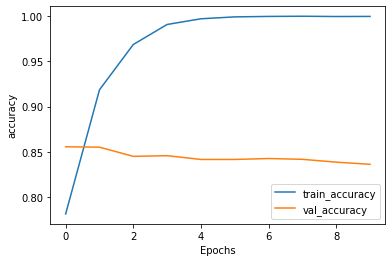

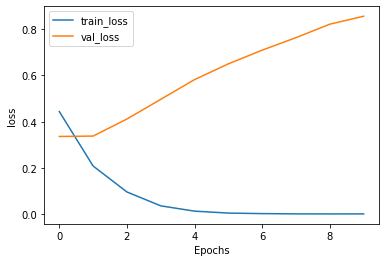

In [30]:
plot_graphs(model_result, "accuracy")
plot_graphs(model_result, "loss")

In [31]:
# predict on new headlines

In [67]:
sentence1 = "Singing is the best job in music industry"
sentence2 = "Asking him to work properly is as good as beating a dead horse"
sentence3 = "The parliament debate was so good, it was like discussion between husband and wife"
sentence4 = "Light travels faster than sound. This is why some people appear bright until they speak"
predict_sequence = tokenizer.texts_to_sequences([sentence1, sentence2, sentence3, sentence4])
print(predict_sequence)

[[3029, 11, 4, 99, 230, 5, 402, 848], [858, 107, 2, 150, 4758, 11, 27, 130, 27, 2547, 7, 170, 1632], [4, 3517, 234, 73, 108, 130, 28, 73, 58, 7491, 379, 1321, 9, 382], [856, 8289, 4354, 78, 1138, 20, 11, 46, 155, 69, 2317, 5293, 423, 94, 1339]]


In [68]:
predict_padded = pad_sequences(predict_sequence, maxlen = max_length)
print(predict_padded)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0 3029   11    4   99
   230    5  402  848]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  858  107    2  150 4758   11   27  130   27
  2547    7  170 1632]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    4 3517  234   73  108  130   28   73   58 7491
   379 1321    9  382]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  856 8289 4354   78 1138   20   11   46  155   69 2317
  5293  423   94 1339]]


In [69]:
model.predict(predict_padded)

array([[1.4901161e-06],
       [1.4241040e-03],
       [9.9635100e-01],
       [1.7881393e-07]], dtype=float32)

In [71]:
import io

In [72]:
# Tensor flow projector is used to visualize the word in a 3D space
# We need to write vector and metadata output files for this
# TensorFlow projectors read these file type and uses it to
# plot the vectors in 3D space
# Metadata file contains 'words' and vector file contains 'embeddings'
# corresponding to these words

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [73]:
# https://projector.tensorflow.org/
# use, word2vec 10K, load both files and click on spherical

# ----------------Single Layer Simple RNN---------------------

In [75]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim = vocab_size,
        output_dim = embedding_dim,
        input_length = max_length),
        tf.keras.layers.SimpleRNN(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(24, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
    ])

In [76]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                5184      
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 166,769
Trainable params: 166,769
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.compile(loss = 'binary_crossentropy', 
             optimizer = 'adam',
             metrics = ['accuracy'])

In [85]:
num_epochs = 10
model.fit(training_padded,
         training_labels,
         epochs = num_epochs,
         validation_data = (testing_padded, testing_labels))

Train on 20000 samples, validate on 6709 samples
Epoch 1/10
20000/20000 [==============================] - 26s 1ms/sample - loss: 0.6895 - accuracy: 0.5486 - val_loss: 0.6784 - val_accuracy: 0.5581
Epoch 2/10
20000/20000 [==============================] - 20s 1ms/sample - loss: 0.4258 - accuracy: 0.7958 - val_loss: 0.3813 - val_accuracy: 0.8325
Epoch 3/10
20000/20000 [==============================] - 18s 887us/sample - loss: 0.1466 - accuracy: 0.9462 - val_loss: 0.5068 - val_accuracy: 0.8024
Epoch 4/10
20000/20000 [==============================] - 19s 933us/sample - loss: 0.0426 - accuracy: 0.9863 - val_loss: 0.6966 - val_accuracy: 0.7895
Epoch 5/10
20000/20000 [==============================] - 18s 905us/sample - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.7761 - val_accuracy: 0.8156
Epoch 6/10
20000/20000 [==============================] - 19s 927us/sample - loss: 0.0095 - accuracy: 0.9970 - val_loss: 0.9303 - val_accuracy: 0.8000
Epoch 7/10
20000/20000 [=========================

In [86]:
model.predict(predict_padded)

array([[3.2949448e-04],
       [1.0102987e-05],
       [9.9999547e-01],
       [9.5844269e-05]], dtype=float32)

# -----------Single layer simple bidirectional-------------------

In [79]:
# Model instantiation - Embedding layer for Text embedding

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim = vocab_size,
        output_dim = embedding_dim,
        input_length = max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = 64)),
        tf.keras.layers.Dense(24, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
    ])

In [80]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               10368     
_________________________________________________________________
dense_10 (Dense)             (None, 24)                3096      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 25        
Total params: 173,489
Trainable params: 173,489
Non-trainable params: 0
_________________________________________________________________


# ------------multilayer simple---------------------------
#return_sequences = True ensures output of one layer matches with the input of next one

In [82]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim = vocab_size,
        output_dim = embedding_dim,
        input_length = max_length),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 32),
        tf.keras.layers.Dense(24, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
    ])